# IT Job Market Deep Dive Analysis (Enhanced)

## 1. Introduction
This notebook performs a deep dive analysis into the IT/Technology sector using the LinkedIn Job Postings dataset (1.3M records). 
We focus on:
- **Trend Analysis**: Job volume over time and work mode (Remote/Onsite).
- **Skill Analysis**: Most in-demand skills for IT professionals (Hard vs. Soft Skills).
- **Geographic Analysis**: Hotspots for IT jobs.
- **Job Title Analysis**: Clustering common roles.

In [ ]:
!pip install pyspark
!pip install nbformat

In [11]:
# Imports and Spark Session Setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when, count, desc, sum, array_contains, split, regexp_extract, to_date, month, year, lit, size, explode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

spark = (
    SparkSession.builder
    .appName("ITJobMarketDeepDive")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "10g")
    .getOrCreate()
)

# Set Plot Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Data Loading & Preprocessing

In [ ]:
# File Paths
file_path_job_postings = "../resources/linkedin_job_postings.csv"
file_path_job_skills = "../resources/job_skills.csv"
file_path_job_summary = "../resources/job_summary.csv"

# Load Datasets
df_postings = spark.read.csv(file_path_job_postings, header=True, escape='"', inferSchema=True)
df_skills = spark.read.csv(file_path_job_skills, header=True, escape='"', inferSchema=True)
df_job_summary = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .option("multiline","true")\
  .option("quote", '"')\
  .option("escape", '\"')\
  .load(file_path_job_summary)

# IT Keyword Filter
strict_keywords = ["AI", "IT", "Web", "QA", "UI", "UX", "ML"]
broad_keywords = [
    "Software", "Developer", "Engineer", "Data", "Analyst", "Cyber", 
    "Cloud", "Network", "System", "Database", "Machine Learning", 
    "DevOps", "Programmer", "Technical", "Information Technology",
    "Security", "Architect", "Scrum", "Product Owner", "Java", "Python", "Javascript"
]
strict_regex = "|".join([f"\\b{k}\\b" for k in strict_keywords])
broad_regex = "|".join(broad_keywords)
combined_regex = f"(?i)({strict_regex}|{broad_regex})"

df_it_jobs = df_postings.filter(col("job_title").rlike(combined_regex))

# Cleaning & Prep
df_clean = df_it_jobs.withColumn(
    "work_mode", 
    when(lower(col("job_type")).rlike("remote"), "Remote")
    .when(lower(col("job_type")).rlike("hybrid"), "Hybrid")
    .when(lower(col("job_type")).rlike("onsite"), "Onsite")
    .otherwise("Unknown")
)

# Join Skills
df_it_full = df_clean.join(df_skills, "job_link", "left")

## 3. Trend Analysis Visualization

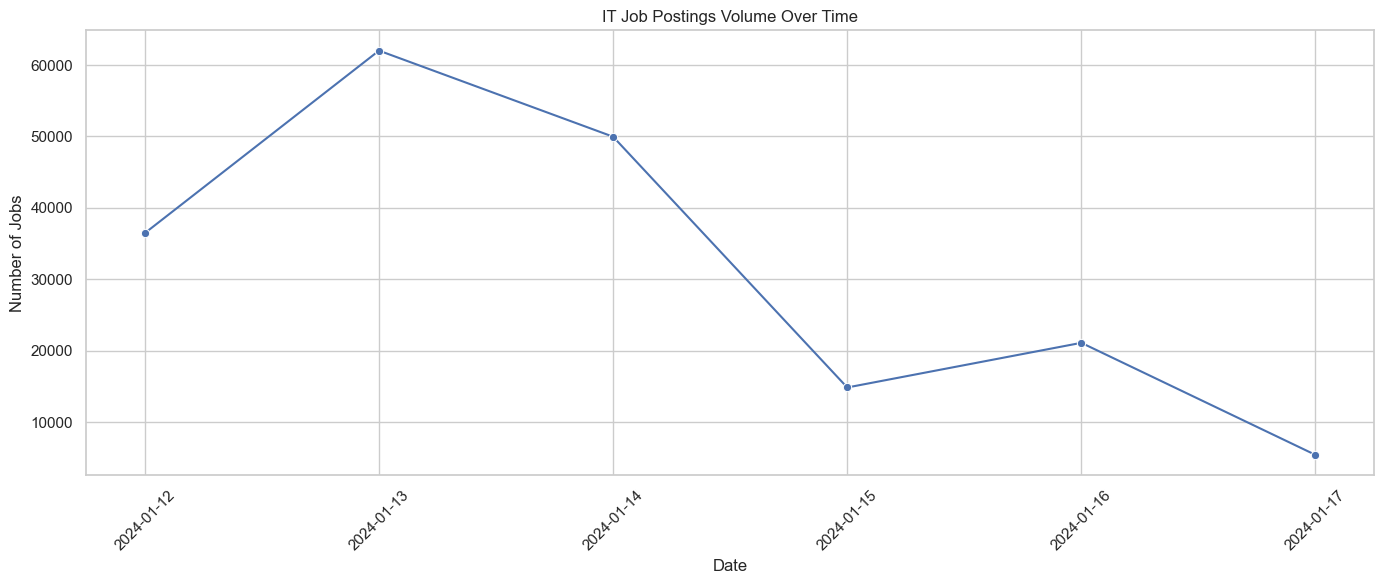

In [13]:
# Prepare Data for Plotting (Convert to Pandas)
df_trend = df_it_full.withColumn("date", to_date(col("first_seen")))\
    .groupBy("date")\
    .count()\
    .orderBy("date")\
    .toPandas()

# Plotting Job Volume
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_trend, x="date", y="count", marker="o", color="b")
plt.title("IT Job Postings Volume Over Time")
plt.ylabel("Number of Jobs")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Work Mode Distribution

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/2813591113.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




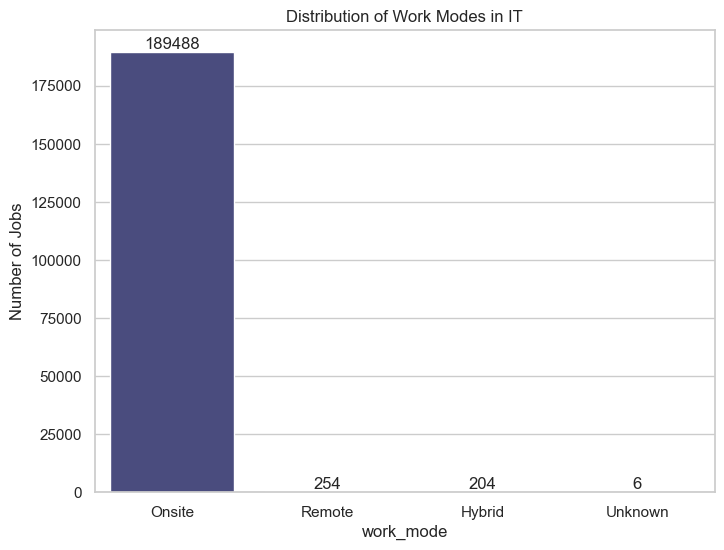

In [14]:
df_work_mode = df_it_full.groupBy("work_mode").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_work_mode, x="work_mode", y="count", palette="viridis")
plt.title("Distribution of Work Modes in IT")
plt.ylabel("Number of Jobs")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

## 4. Skill Analysis (Categorized)
Separating **Soft Skills** (Communication, Leadership) from **Hard Skills** (Python, AWS).

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/369887438.py:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/369887438.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




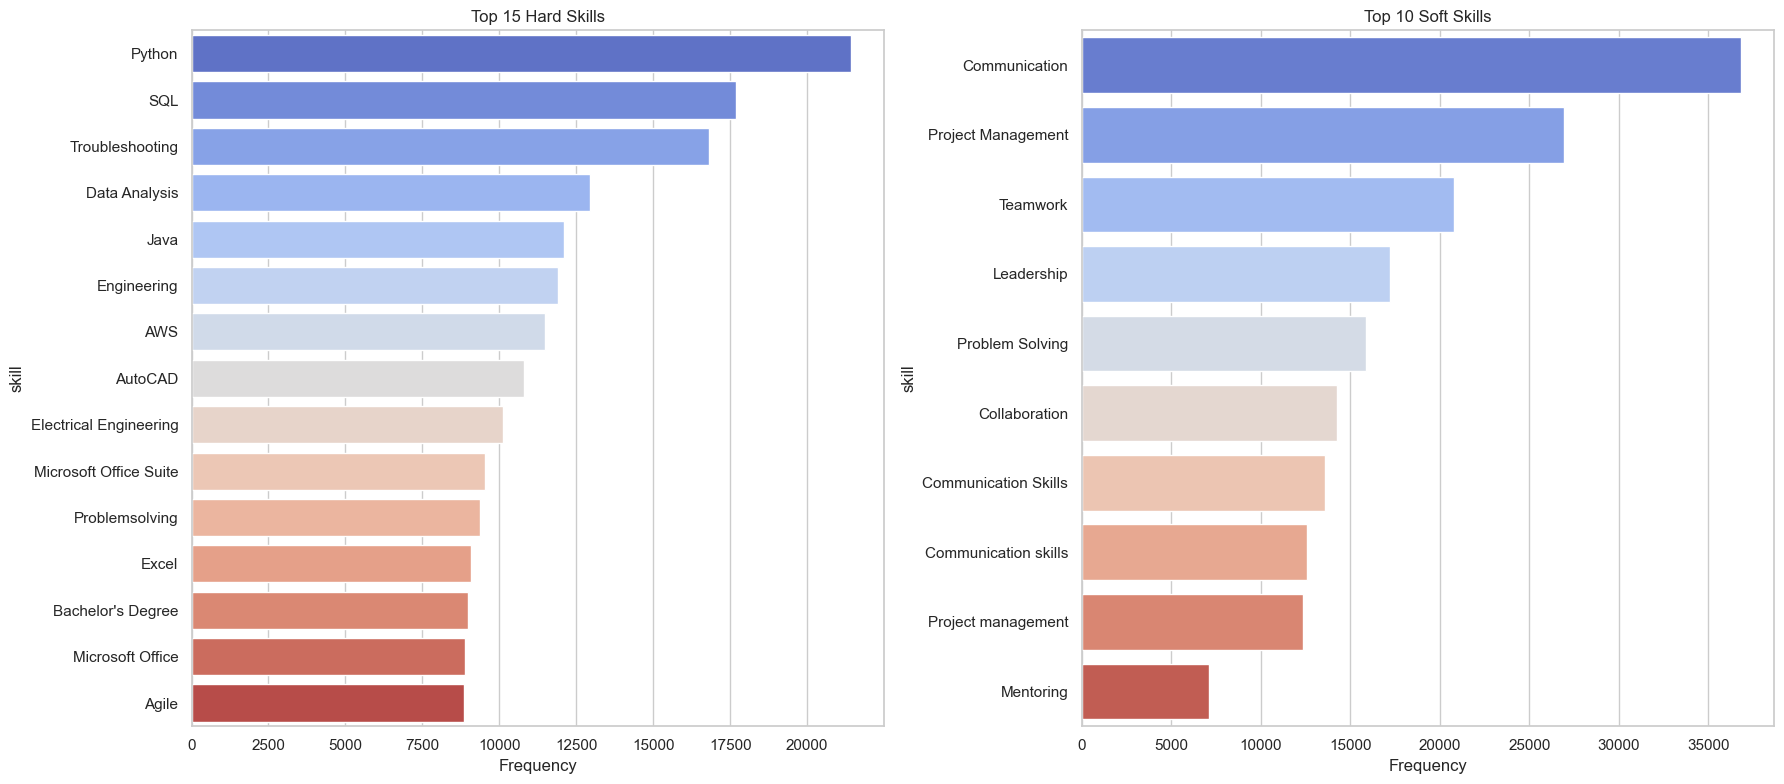

In [15]:
# Function to categorize skills
# We first define lists. Ideally this is done via a lookup table, but we will use a set of common keywords.
soft_skills_list = [
    "Communication", "Leadership", "Teamwork", "Problem Solving", "Time Management", 
    "Adaptability", "Creativity", "Work Ethic", "Interpersonal Skills", "Critical Thinking",
    "Collaboration", "Management", "Organization", "Planning", "Mentoring"
]

# Normalize function for easier matching
soft_skills_lower = [s.lower() for s in soft_skills_list]

# Explode skills
df_skills_all = df_it_full.filter(col("job_skills").isNotNull())\
    .withColumn("skill", explode(split(col("job_skills"), ",\\s*")))\
    .groupBy("skill")\
    .count()\
    .orderBy(desc("count"))\
    .toPandas()

# Categorize in Pandas
def categorize_skill(skill_name):
    s_clean = str(skill_name).lower()
    if any(soft in s_clean for soft in soft_skills_lower):
        return "Soft Skill"
    return "Hard Skill"

df_skills_all["Category"] = df_skills_all["skill"].apply(categorize_skill)

# Top 15 Hard Skills
top_hard = df_skills_all[df_skills_all["Category"] == "Hard Skill"].head(15)

# Top 10 Soft Skills
top_soft = df_skills_all[df_skills_all["Category"] == "Soft Skill"].head(10)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Hard Skills
sns.barplot(data=top_hard, y="skill", x="count", ax=axes[0], palette="coolwarm")
axes[0].set_title("Top 15 Hard Skills")
axes[0].set_xlabel("Frequency")

# Soft Skills
sns.barplot(data=top_soft, y="skill", x="count", ax=axes[1], palette="coolwarm")
axes[1].set_title("Top 10 Soft Skills")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

## 5. Geographical Analysis (Map)
Mapping the job volume by Country.

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/3980265397.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




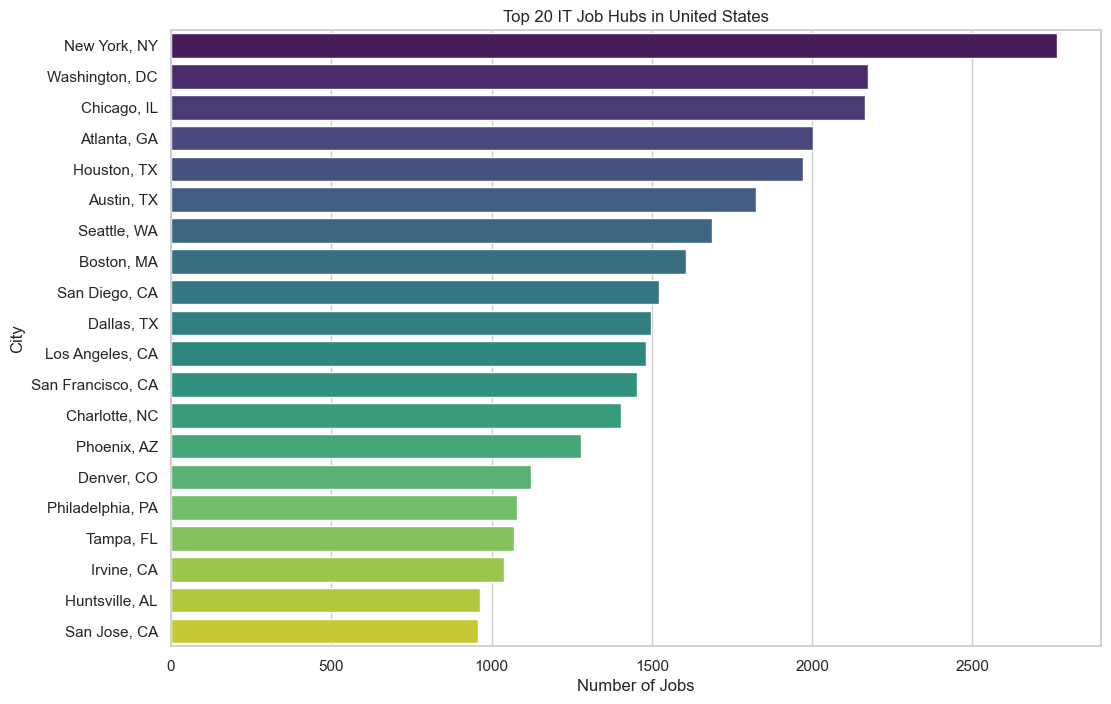

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/3980265397.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




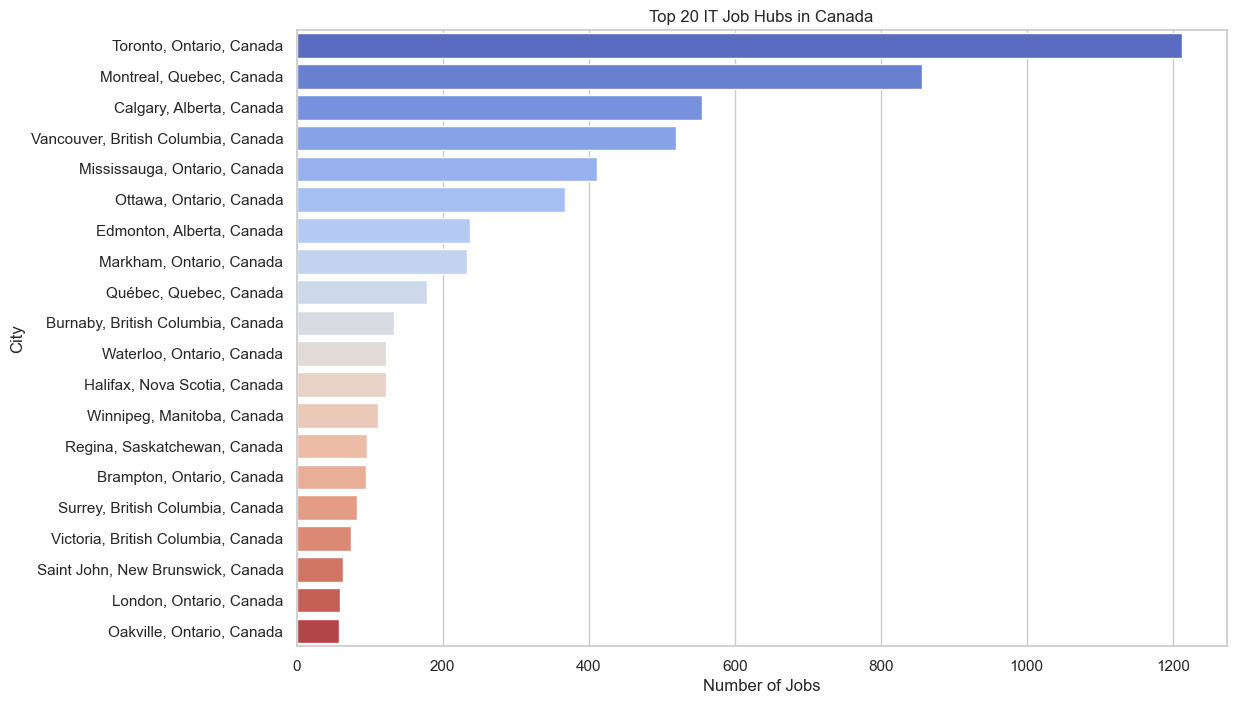

In [16]:
# 5.1 City-Level Analysis (US & Canada)
# Filter for US and Canada only
df_geo_city = df_it_full.filter(col("search_country").isin(["United States", "Canada"]))

# Group by Location (City, State)
# We use 'job_location' as it usually contains "City, State"
df_city_counts = df_geo_city.filter(col("job_location").isNotNull())\
    .groupBy("search_country", "job_location")\
    .count()\
    .orderBy(desc("count"))\
    .toPandas()

# Separate US and Canada for cleaner plots
df_us_cities = df_city_counts[df_city_counts['search_country'] == 'United States'].head(20)
df_ca_cities = df_city_counts[df_city_counts['search_country'] == 'Canada'].head(20)

# Plot Top 20 US Cities
plt.figure(figsize=(12, 8))
sns.barplot(data=df_us_cities, y="job_location", x="count", palette="viridis")
plt.title("Top 20 IT Job Hubs in United States")
plt.xlabel("Number of Jobs")
plt.ylabel("City")
plt.show()

# Plot Top 20 Canadian Cities
plt.figure(figsize=(12, 8))
sns.barplot(data=df_ca_cities, y="job_location", x="count", palette="coolwarm")
plt.title("Top 20 IT Job Hubs in Canada")
plt.xlabel("Number of Jobs")
plt.ylabel("City")
plt.show()

## 6. Job Title Clusters

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_55360/2921620740.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




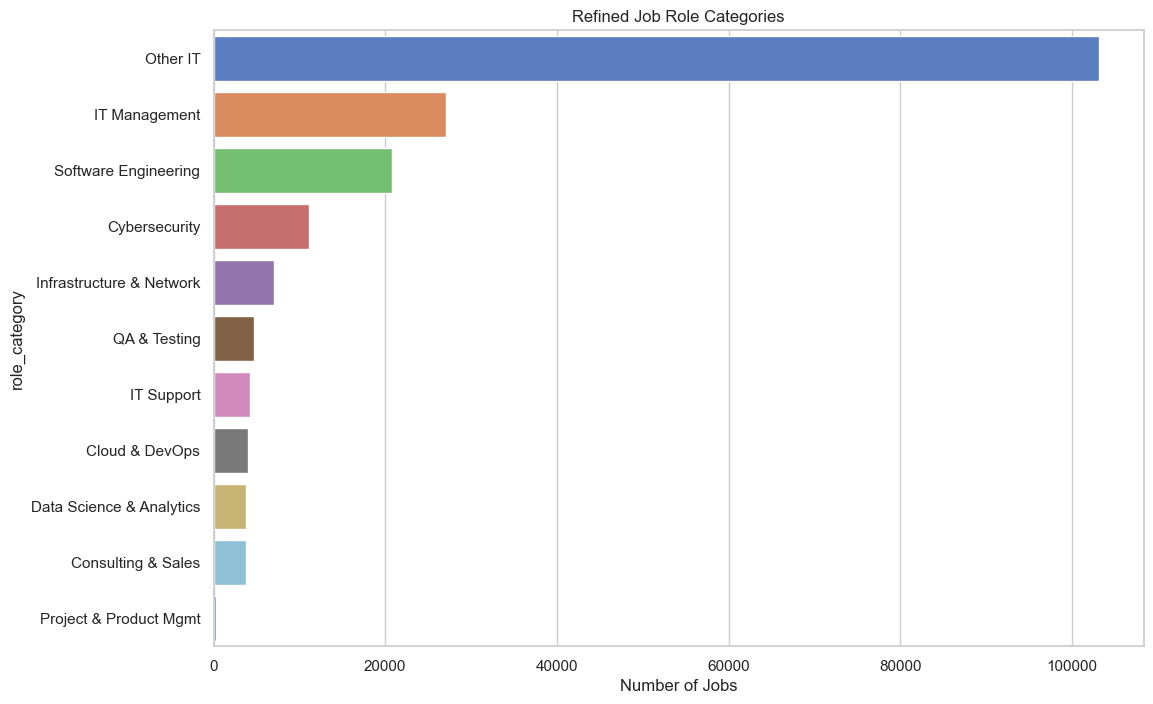

In [17]:
df_roles = df_it_full.withColumn(
    "role_category",
    when(col("job_title").rlike("(?i)data scientist|data analyst|machine learning|ai engineer"), "Data Science & Analytics")
    .when(col("job_title").rlike("(?i)software engineer|developer|programmer|full stack|backend|frontend"), "Software Engineering")
    .when(col("job_title").rlike("(?i)cloud|devops|sre|reliability|platform engineer"), "Cloud & DevOps")
    .when(col("job_title").rlike("(?i)manager|director|lead|head|vp|chief"), "IT Management")
    .when(col("job_title").rlike("(?i)project manager|product manager|scrum|agile|product owner"), "Project & Product Mgmt")
    .when(col("job_title").rlike("(?i)qa|test|quality assurance|automation"), "QA & Testing")
    .when(col("job_title").rlike("(?i)consultant|solution|sales engineer|pre-sales|technical account"), "Consulting & Sales")
    .when(col("job_title").rlike("(?i)support|technician|help desk|service desk"), "IT Support")
    .when(col("job_title").rlike("(?i)network|system admin|infrastructure|sysadmin"), "Infrastructure & Network")
    .when(col("job_title").rlike("(?i)cyber|security|infosec"), "Cybersecurity")
    .otherwise("Other IT")
).groupBy("role_category").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=df_roles, y="role_category", x="count", palette="muted")
plt.title("Refined Job Role Categories")
plt.xlabel("Number of Jobs")
plt.show()